In [1]:
!pip install mlxtend --user
!pip install lightgbm --user
!pip install xgboost --user
!pip install plotly --user

     |████████████████████████████████| 1.3 MB 38.1 MB/s            
     |████████████████████████████████| 31.2 MB 130.4 MB/s            
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 2.0 MB 34.2 MB/s            
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 193.6 MB 177 kB/s              
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 15.3 MB 4.7 MB/s            
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [1]:
import os

cwd=os.path.abspath('')
os.chdir('/mnt')
files=os.listdir(cwd)

In [2]:
import os
import pandas as pd
import scipy as sp
import numpy as np
import math
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from sklearn.preprocessing import PowerTransformer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing

In [3]:
def rmse(y, y_pred):
    return np.sqrt(np.mean((y - y_pred)**2))

def mae(y, y_pred):
    return np.mean(np.absolute(np.subtract(y, y_pred)))

In [4]:
#Yeo-Johnson and Box Cox Transformation, water column retained
df = pd.read_csv('/mnt/Datasets/merged_dataframe_11_30_2022.csv').drop(columns = ['Unnamed: 0'])
df = df.drop(columns = ['Field_Name'])

#train/test split
train_Yield_kg_per_ha, test_Yield_kg_per_ha = train_test_split(df, test_size = 0.2, random_state = 50)

#x values
X_train_yield_kg_per_ha = train_Yield_kg_per_ha[['CO2_kg_Emissions_per_Ha']]
X_test_yield_kg_per_ha = test_Yield_kg_per_ha[['CO2_kg_Emissions_per_Ha']]

power_transform_X = PowerTransformer(standardize = True).fit(X_train_yield_kg_per_ha)

X_train_yield_kg_per_ha = power_transform_X.transform(X_train_yield_kg_per_ha)

X_test_yield_kg_per_ha = power_transform_X.transform(X_test_yield_kg_per_ha)

#y_values
y_train_yield_per_ha = np.array(train_Yield_kg_per_ha['Yield_Mass_kg_Per_Ha']).reshape(-1, 1)
mean_Yield_kg_per_ha = y_train_yield_per_ha.mean()
y_test_yield_per_ha = np.array(test_Yield_kg_per_ha['Yield_Mass_kg_Per_Ha']).reshape(-1, 1)

power_transform_y = PowerTransformer(standardize = True, method = 'box-cox').fit(y_train_yield_per_ha)

y_train_yield_per_ha = power_transform_y.transform(y_train_yield_per_ha)
y_test_yield_per_ha = power_transform_y.transform(y_test_yield_per_ha)

In [5]:
####Initialize K fold Cross validation
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

#####Grid Space for Lasso, Ridge, ElasticNet
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

####Model Building

model_names = ['OLS', 'Lasso', 'Ridge', 'ElasticNet', 'SVR', 'Lightgbm', 'GBR', 'XGBoost']
models = [linear_model.LinearRegression(), \
            LassoCV(max_iter = int(1e7), alphas = alphas2, random_state = 42, cv = kfolds), \
                  RidgeCV(alphas = alphas_alt, cv = kfolds), \
                  ElasticNetCV(max_iter = int(1e7), alphas = e_alphas, cv = kfolds, l1_ratio = e_l1ratio), \
                  SVR(C = 20, epsilon = 0.008, gamma = 0.0003), \
                  LGBMRegressor(objective='regression', num_leaves = 4, learning_rate = 0.01, n_estimators = 5000, max_bin = 200, bagging_fraction = 0.75, \
                                bagging_freq = 5, bagging_seed = 7, feature_fraction = 0.2, feature_fraction_seed = 7, verbose = -1), \
                  GradientBoostingRegressor(n_estimators = 5000, learning_rate = 0.05, max_depth = 4, max_features = 'sqrt', min_samples_leaf = 15, \
                                            min_samples_split = 10, loss = 'huber', random_state = 42), \
                  XGBRegressor(learning_rate = 0.005, n_estimators = 10000, max_depth = 3, min_child_weight = 0, gamma = 0, subsample = 0.7, \
                               colsample_bytree = 0.7, objective = 'reg:linear', nthread = -1, scale_pos_weight = 1, seed = 27, reg_alpha = 0.00006)
         ]

fitted_models = []
Test_MAE_models = []
Test_Scaled_MAE_models = []

for model in models:
    fitted_models.append(model.fit(X_train_yield_kg_per_ha, y_train_yield_per_ha))
    inv_transform_y_actuals = power_transform_y.inverse_transform(y_test_yield_per_ha).reshape(-1, 1)
    inv_transformed_preds = power_transform_y.inverse_transform(fitted_models[models.index(model)].predict(X_test_yield_kg_per_ha).reshape(-1,1))                                      
    Test_MAE_models.append(mae(inv_transform_y_actuals, inv_transformed_preds))
    Test_Scaled_MAE_models.append(Test_MAE_models[models.index(model)]/mean_Yield_kg_per_ha)
                                                                                                    
#stacked model
model_names.append('stackgen')
models.append(StackingCVRegressor(regressors = (models[0], models[1], models[2], models[3], models[4], models[5], models[6], models[7]), meta_regressor = models[7], use_features_in_secondary = True))
fitted_models.append(models[8].fit(X_train_yield_kg_per_ha, y_train_yield_per_ha))
inv_transform_y_actuals = power_transform_y.inverse_transform(y_test_yield_per_ha).reshape(-1,1)
inv_transformed_preds = power_transform_y.inverse_transform(fitted_models[8].predict(X_test_yield_kg_per_ha).reshape(-1,1))                                                 
Test_MAE_models.append(mae(inv_transform_y_actuals, inv_transformed_preds))
Test_Scaled_MAE_models.append(Test_MAE_models[8]/mean_Yield_kg_per_ha)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[18:54:09] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_f

OLS
MAE on test data: 917.3242941190547
MAE Scaled on test data: 0.25565890902476657


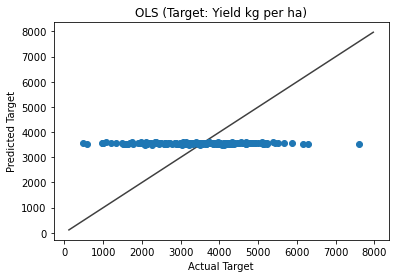

Lasso
MAE on test data: 917.4469711386569
MAE Scaled on test data: 0.25569309919414834


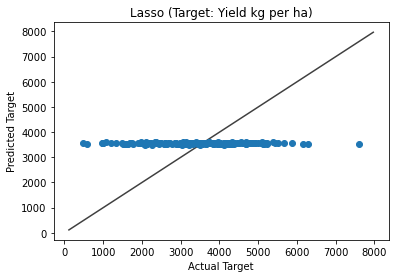

Ridge
MAE on test data: 917.3871458589593
MAE Scaled on test data: 0.2556764258477237


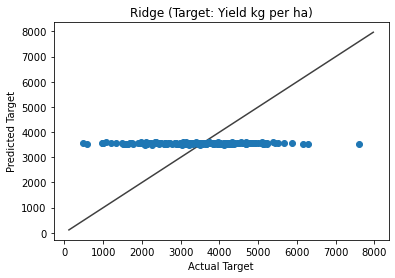

ElasticNet
MAE on test data: 917.4316362386925
MAE Scaled on test data: 0.25568882534702575


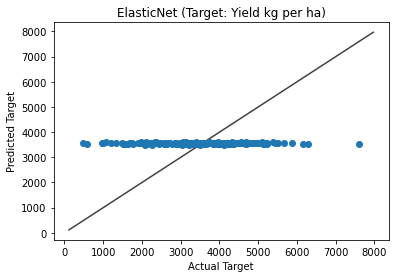

SVR
MAE on test data: 912.8939197465604
MAE Scaled on test data: 0.25442416065289347


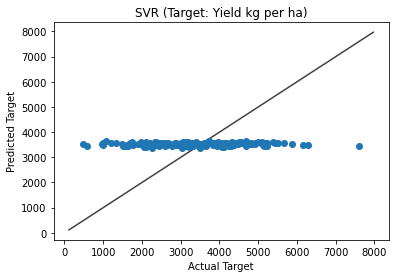

Lightgbm
MAE on test data: 933.7249981400005
MAE Scaled on test data: 0.26022979646785976


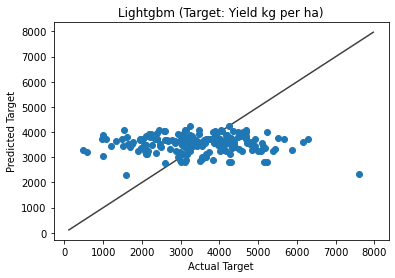

GBR
MAE on test data: 1020.1441319063005
MAE Scaled on test data: 0.2843148682349552


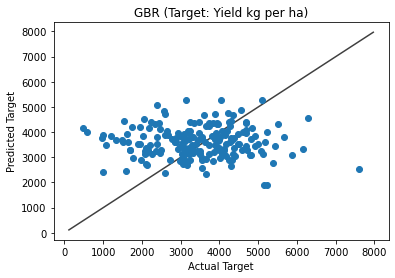

XGBoost
MAE on test data: 972.5530924250197
MAE Scaled on test data: 0.27105121293754114


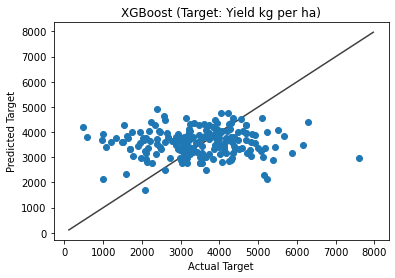

stackgen
MAE on test data: 986.3913939008869
MAE Scaled on test data: 0.2749079570363918


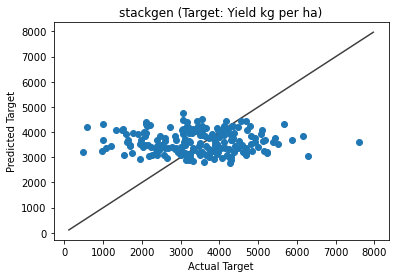

In [6]:
for model_name in model_names:
    print(model_name)
    print('MAE on test data: ' + str(Test_MAE_models[model_names.index(model_name)]))
    print('MAE Scaled on test data: ' + str(Test_Scaled_MAE_models[model_names.index(model_name)]))
    inv_transformed_y_actuals = power_transform_y.inverse_transform(y_test_yield_per_ha).reshape(-1, 1)
    inv_transformed_preds = power_transform_y.inverse_transform(fitted_models[model_names.index(model_name)].predict(X_test_yield_kg_per_ha).reshape(-1,1))
    fig, ax = plt.subplots()
    ax.scatter(inv_transformed_y_actuals, inv_transformed_preds)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Actual Target')
    plt.ylabel('Predicted Target')
    plt.title(model_name + ' (Target: Yield kg per ha)')
    plt.show()

In [7]:
from sklearn.inspection import permutation_importance

for i in range(len(fitted_models)):
    feature_names = X_train_yield_kg_per_ha.columns

    result = permutation_importance(
        fitted_models[i], X_test_yield_kg_per_ha, y_test_yield_per_ha, n_repeats=10, random_state=42, n_jobs=2
    )

    model_importances = pd.Series(result.importances_mean, index = feature_names)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    model_importances.plot.bar(yerr = result.importances_std, ax = ax)
    ax.set_title("Feature importances using permutation on full model (" + str(model_names[i]) + ')')
    ax.set_ylabel("Mean Accuracy decrease")
    plt.grid()
    fig.tight_layout()
    plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [14]:
#Yeo-Johnson and Box Cox Transformation, water column retained, outliers removed
df = pd.read_csv('/mnt/Datasets/merged_dataframe_11_30_2022.csv').drop(columns = ['Unnamed: 0'])
df = df.drop(columns = ['Field_Name'])

df = df[(df['Yield_Mass_kg_Per_Ha'] >= df['Yield_Mass_kg_Per_Ha'].quantile(.05)) & (df['Yield_Mass_kg_Per_Ha'] <= df['Yield_Mass_kg_Per_Ha'].quantile(.95))].reset_index(drop = True)

#train/test split
train_Yield_kg_per_ha, test_Yield_kg_per_ha = train_test_split(df, test_size = 0.2, random_state = 50)

#x values
X_train_yield_kg_per_ha = train_Yield_kg_per_ha[['CO2_kg_Emissions_per_Ha']]
X_test_yield_kg_per_ha = test_Yield_kg_per_ha[['CO2_kg_Emissions_per_Ha']]

power_transform_X = PowerTransformer(standardize = True).fit(X_train_yield_kg_per_ha)

X_train_yield_kg_per_ha = power_transform_X.transform(X_train_yield_kg_per_ha)

X_test_yield_kg_per_ha = power_transform_X.transform(X_test_yield_kg_per_ha)

#y_values
y_train_yield_per_ha = np.array(train_Yield_kg_per_ha['Yield_Mass_kg_Per_Ha']).reshape(-1, 1)
mean_Yield_kg_per_ha = y_train_yield_per_ha.mean()
y_test_yield_per_ha = np.array(test_Yield_kg_per_ha['Yield_Mass_kg_Per_Ha']).reshape(-1, 1)

power_transform_y = PowerTransformer(standardize = True, method = 'box-cox').fit(y_train_yield_per_ha)

y_train_yield_per_ha = power_transform_y.transform(y_train_yield_per_ha)
y_test_yield_per_ha = power_transform_y.transform(y_test_yield_per_ha)
print(mean_Yield_kg_per_ha)

3532.8000317684805


In [9]:
####Initialize K fold Cross validation
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

#####Grid Space for Lasso, Ridge, ElasticNet
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

####Model Building

model_names = ['OLS', 'Lasso', 'Ridge', 'ElasticNet', 'SVR', 'Lightgbm', 'GBR', 'XGBoost']
models = [linear_model.LinearRegression(), \
            LassoCV(max_iter = int(1e7), alphas = alphas2, random_state = 42, cv = kfolds), \
                  RidgeCV(alphas = alphas_alt, cv = kfolds), \
                  ElasticNetCV(max_iter = int(1e7), alphas = e_alphas, cv = kfolds, l1_ratio = e_l1ratio), \
                  SVR(C = 20, epsilon = 0.008, gamma = 0.0003), \
                  LGBMRegressor(objective='regression', num_leaves = 4, learning_rate = 0.01, n_estimators = 5000, max_bin = 200, bagging_fraction = 0.75, \
                                bagging_freq = 5, bagging_seed = 7, feature_fraction = 0.2, feature_fraction_seed = 7, verbose = -1), \
                  GradientBoostingRegressor(n_estimators = 5000, learning_rate = 0.05, max_depth = 4, max_features = 'sqrt', min_samples_leaf = 15, \
                                            min_samples_split = 10, loss = 'huber', random_state = 42), \
                  XGBRegressor(learning_rate = 0.005, n_estimators = 10000, max_depth = 3, min_child_weight = 0, gamma = 0, subsample = 0.7, \
                               colsample_bytree = 0.7, objective = 'reg:linear', nthread = -1, scale_pos_weight = 1, seed = 27, reg_alpha = 0.00006)
         ]

fitted_models = []
Test_MAE_models = []
Test_Scaled_MAE_models = []

for model in models:
    fitted_models.append(model.fit(X_train_yield_kg_per_ha, y_train_yield_per_ha))
    inv_transform_y_actuals = power_transform_y.inverse_transform(y_test_yield_per_ha).reshape(-1, 1)
    inv_transformed_preds = power_transform_y.inverse_transform(fitted_models[models.index(model)].predict(X_test_yield_kg_per_ha).reshape(-1,1))                                      
    Test_MAE_models.append(mae(inv_transform_y_actuals, inv_transformed_preds))
    Test_Scaled_MAE_models.append(Test_MAE_models[models.index(model)]/mean_Yield_kg_per_ha)
                                                                                                    
#stacked model
model_names.append('stackgen')
models.append(StackingCVRegressor(regressors = (models[0], models[1], models[2], models[3], models[4], models[5], models[6], models[7]), meta_regressor = models[7], use_features_in_secondary = True))
fitted_models.append(models[8].fit(X_train_yield_kg_per_ha, y_train_yield_per_ha))
inv_transform_y_actuals = power_transform_y.inverse_transform(y_test_yield_per_ha).reshape(-1,1)
inv_transformed_preds = power_transform_y.inverse_transform(fitted_models[8].predict(X_test_yield_kg_per_ha).reshape(-1,1))                                                 
Test_MAE_models.append(mae(inv_transform_y_actuals, inv_transformed_preds))
Test_Scaled_MAE_models.append(Test_MAE_models[8]/mean_Yield_kg_per_ha)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[21:00:13] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_f

OLS
MAE on test data: 782.7939367360688
MAE Scaled on test data: 0.22157889767234032


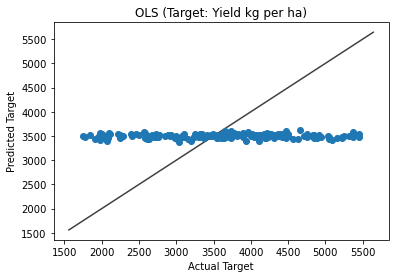

Lasso
MAE on test data: 782.8586090505391
MAE Scaled on test data: 0.22159720392061047


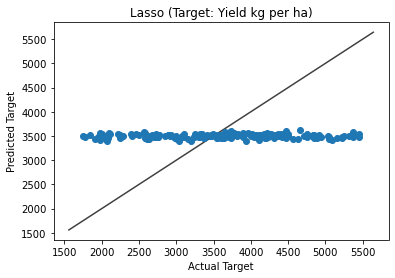

Ridge
MAE on test data: 782.8910101799715
MAE Scaled on test data: 0.2216063754358791


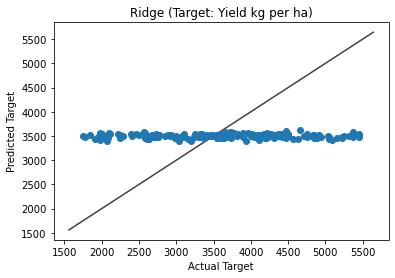

ElasticNet
MAE on test data: 782.8462966612541
MAE Scaled on test data: 0.22159371875610234


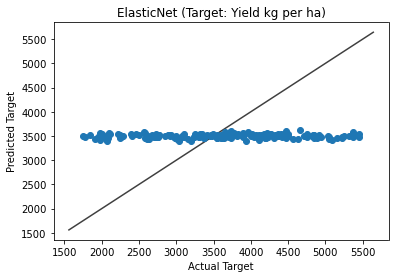

SVR
MAE on test data: 782.0994330903901
MAE Scaled on test data: 0.2213823103649826


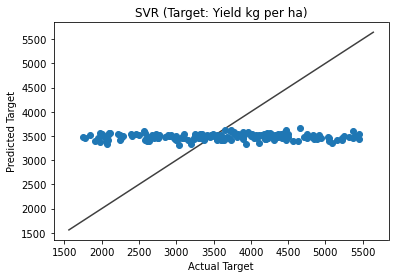

Lightgbm
MAE on test data: 834.0518052494309
MAE Scaled on test data: 0.2360880315187027


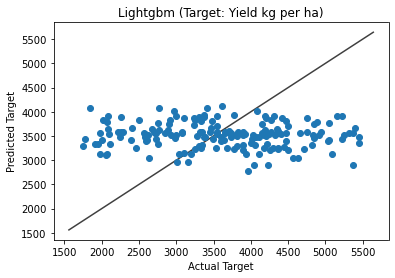

GBR
MAE on test data: 936.2316324286064
MAE Scaled on test data: 0.26501121603532685


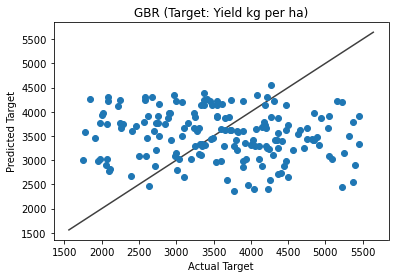

XGBoost
MAE on test data: 926.8969843930458
MAE Scaled on test data: 0.2623689357048187


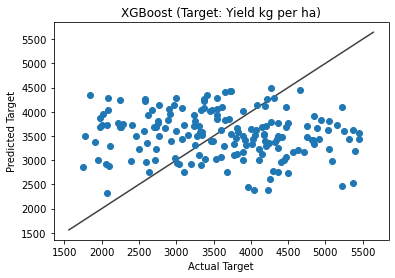

stackgen
MAE on test data: 802.1230968900664
MAE Scaled on test data: 0.22705024051093334


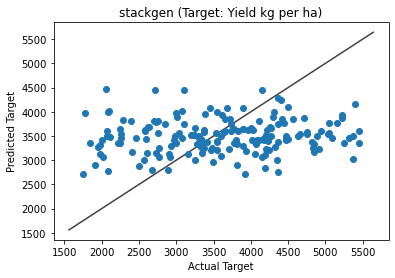

In [10]:
for model_name in model_names:
    print(model_name)
    print('MAE on test data: ' + str(Test_MAE_models[model_names.index(model_name)]))
    print('MAE Scaled on test data: ' + str(Test_Scaled_MAE_models[model_names.index(model_name)]))
    inv_transformed_y_actuals = power_transform_y.inverse_transform(y_test_yield_per_ha).reshape(-1, 1)
    inv_transformed_preds = power_transform_y.inverse_transform(fitted_models[model_names.index(model_name)].predict(X_test_yield_kg_per_ha).reshape(-1,1))
    fig, ax = plt.subplots()
    ax.scatter(inv_transformed_y_actuals, inv_transformed_preds)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Actual Target')
    plt.ylabel('Predicted Target')
    plt.title(model_name + ' (Target: Yield kg per ha)')
    plt.show()

In [11]:
from sklearn.inspection import permutation_importance

for i in range(len(fitted_models)):
    feature_names = X_train_yield_kg_per_ha.columns

    result = permutation_importance(
        fitted_models[i], X_test_yield_kg_per_ha, y_test_yield_per_ha, n_repeats=10, random_state=42, n_jobs=2
    )

    model_importances = pd.Series(result.importances_mean, index = feature_names)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    model_importances.plot.bar(yerr = result.importances_std, ax = ax)
    ax.set_title("Feature importances using permutation on full model (" + str(model_names[i]) + ')')
    ax.set_ylabel("Mean Accuracy decrease")
    plt.grid()
    fig.tight_layout()
    plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [24]:
#Yeo-Johnson and Box Cox Transformation
df = pd.read_csv('/mnt/Datasets/merged_dataframe_11_30_2022.csv').drop(columns = ['Unnamed: 0'])
df = df.drop(columns = ['Field_Name', 'Total_Water_Applied_mm'])

print(display(df))

#train/test split

train_Yield_kg_per_ha, test_Yield_kg_per_ha = train_test_split(df, test_size = 0.2, random_state = 50)

# #x values
X_train_yield_kg_per_ha = train_Yield_kg_per_ha.drop(columns = ['Yield_Mass_kg_Per_Ha'])
X_test_yield_kg_per_ha = test_Yield_kg_per_ha.drop(columns = ['Yield_Mass_kg_Per_Ha'])

power_transform_X = PowerTransformer(standardize = True).fit(X_train_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'CO2_kg_Emissions_per_Ha']])

X_train_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'CO2_kg_Emissions_per_Ha']] = \
power_transform_X.transform(X_train_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'CO2_kg_Emissions_per_Ha']])

X_test_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'CO2_kg_Emissions_per_Ha']] = \
power_transform_X.transform(X_test_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'CO2_kg_Emissions_per_Ha']])

power_transform_X_CO2 = PowerTransformer(standardize = True, method = 'box-cox').fit(X_train_yield_kg_per_ha[['Soil_Organic_Matter', 'Total_Water_Applied_mm_per_Ha', 'Crop_Protection_Application_Doses']])

X_train_yield_kg_per_ha[['Soil_Organic_Matter', 'Total_Water_Applied_mm_per_Ha', 'Crop_Protection_Application_Doses']] = \
power_transform_X_CO2.transform(X_train_yield_kg_per_ha[['Soil_Organic_Matter', 'Total_Water_Applied_mm_per_Ha', 'Crop_Protection_Application_Doses']])

X_test_yield_kg_per_ha[['Soil_Organic_Matter', 'Total_Water_Applied_mm_per_Ha', 'Crop_Protection_Application_Doses']] = \
power_transform_X_CO2.transform(X_test_yield_kg_per_ha[['Soil_Organic_Matter', 'Total_Water_Applied_mm_per_Ha', 'Crop_Protection_Application_Doses']])


# #y_values
y_train_yield_per_ha = np.array(train_Yield_kg_per_ha['Yield_Mass_kg_Per_Ha']).reshape(-1, 1)
y_test_yield_per_ha = np.array(test_Yield_kg_per_ha['Yield_Mass_kg_Per_Ha']).reshape(-1, 1)

mean_Yield_kg_per_ha = y_train_yield_per_ha.mean()

power_transform_y = PowerTransformer(standardize = True, method = 'box-cox').fit(y_train_yield_per_ha)
y_train_yield_per_ha = power_transform_y.transform(y_train_yield_per_ha)
y_test_yield_per_ha = power_transform_y.transform(y_test_yield_per_ha)

,N_as_Nitrate_kg_per_Ha,P_as_Phosphorus_kg_per_Ha,K_as_Potassium_kg_per_Ha,Soil_Organic_Matter,Yield_Mass_kg_Per_Ha,CO2_kg_Emissions_per_Ha,Total_Water_Applied_mm_per_Ha,Crop_Protection_Application_Doses
0,6000.0,0.0,6000.0,2.50,4786.900000,349.85,1.750000,0.070000
1,6600.0,0.0,6600.0,2.50,5234.476190,488.41,1.666667,0.085714
2,6000.0,0.0,6000.0,2.50,4358.380952,462.26,1.666667,0.095238
3,0.0,0.0,0.0,2.50,3400.400000,409.14,2.333333,0.066667
4,0.0,0.0,0.0,2.50,3033.000000,261.38,5.000000,0.214286
...,...,...,...,...,...,...,...,...
971,0.0,0.0,0.0,2.69,4587.384615,449.67,6.923077,0.246154
972,0.0,0.0,0.0,5.38,6741.676647,-1035.15,5.389222,0.179641
973,0.0,0.0,0.0,5.38,6482.275449,-1092.21,5.389222,0.155689
974,0.0,0.0,0.0,3.75,3372.689076,-427.99,3.781513,0.126050


None


In [25]:
####Initialize K fold Cross validation
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

#####Grid Space for Lasso, Ridge, ElasticNet
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

####Model Building

model_names = ['OLS', 'Lasso', 'Ridge', 'ElasticNet', 'SVR', 'Lightgbm', 'GBR', 'XGBoost']
models = [linear_model.LinearRegression(), \
            LassoCV(max_iter = int(1e7), alphas = alphas2, random_state = 42, cv = kfolds), \
                  RidgeCV(alphas = alphas_alt, cv = kfolds), \
                  ElasticNetCV(max_iter = int(1e7), alphas = e_alphas, cv = kfolds, l1_ratio = e_l1ratio), \
                  SVR(C = 20, epsilon = 0.008, gamma = 0.0003), \
                  LGBMRegressor(objective='regression', num_leaves = 4, learning_rate = 0.01, n_estimators = 5000, max_bin = 200, bagging_fraction = 0.75, \
                                bagging_freq = 5, bagging_seed = 7, feature_fraction = 0.2, feature_fraction_seed = 7, verbose = -1), \
                  GradientBoostingRegressor(n_estimators = 5000, learning_rate = 0.05, max_depth = 4, max_features = 'sqrt', min_samples_leaf = 15, \
                                            min_samples_split = 10, loss = 'huber', random_state = 42), \
                  XGBRegressor(learning_rate = 0.005, n_estimators = 10000, max_depth = 3, min_child_weight = 0, gamma = 0, subsample = 0.7, \
                               colsample_bytree = 0.7, objective = 'reg:linear', nthread = -1, scale_pos_weight = 1, seed = 27, reg_alpha = 0.00006)
         ]

fitted_models = []
Test_MAE_models = []
Test_Scaled_MAE_models = []

for model in models:
    fitted_models.append(model.fit(X_train_yield_kg_per_ha, y_train_yield_per_ha))
    inv_transform_y_actuals = power_transform_y.inverse_transform(y_test_yield_per_ha).reshape(-1, 1)
    inv_transformed_preds = power_transform_y.inverse_transform(fitted_models[models.index(model)].predict(X_test_yield_kg_per_ha).reshape(-1,1))                                      
    Test_MAE_models.append(mae(inv_transform_y_actuals, inv_transformed_preds))
    Test_Scaled_MAE_models.append(Test_MAE_models[models.index(model)]/mean_Yield_kg_per_ha)
                                                                                                    
#stacked model
model_names.append('stackgen')
models.append(StackingCVRegressor(regressors = (models[0], models[1], models[2], models[3], models[4], models[5], models[6], models[7]), meta_regressor = models[6], use_features_in_secondary = True))
fitted_models.append(models[8].fit(X_train_yield_kg_per_ha, y_train_yield_per_ha))
inv_transform_y_actuals = power_transform_y.inverse_transform(y_test_yield_per_ha).reshape(-1,1)
inv_transformed_preds = power_transform_y.inverse_transform(fitted_models[8].predict(X_test_yield_kg_per_ha).reshape(-1,1))                                                 
Test_MAE_models.append(mae(inv_transform_y_actuals, inv_transformed_preds))
Test_Scaled_MAE_models.append(Test_MAE_models[8]/mean_Yield_kg_per_ha)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[18:52:07] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_f

In [69]:
print(Test_MAE_models)
print(Test_Scaled_MAE_models)

[917.6550777991332, 917.6555771491965, 917.6762695422483, 917.6558770370175, 922.1060268848627, 931.7819669323508, 926.3845382129748, 859.4331183603567, 925.0801553971528]
[0.2557510986629504, 0.25575123783215503, 0.25575700481627034, 0.25575132141109613, 0.25699158122149335, 0.25968827233955155, 0.25818400525888974, 0.2395245986925158, 0.2395245986925158]


OLS
MAE on test data: 908.8202203554897
MAE Scaled on test data: 0.25328881784262136


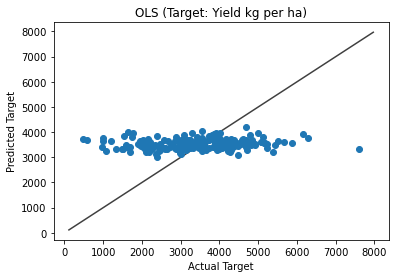

Lasso
MAE on test data: 908.4230230912041
MAE Scaled on test data: 0.2531781186930339


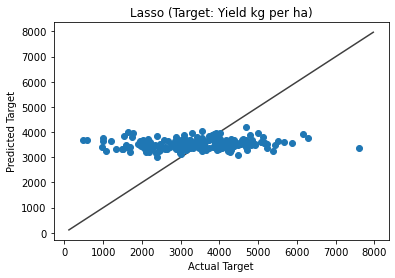

Ridge
MAE on test data: 907.1558104949769
MAE Scaled on test data: 0.25282494567458136


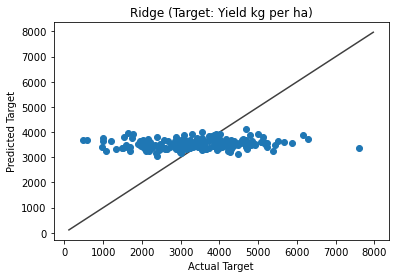

ElasticNet
MAE on test data: 908.4728600608549
MAE Scaled on test data: 0.2531920082906078


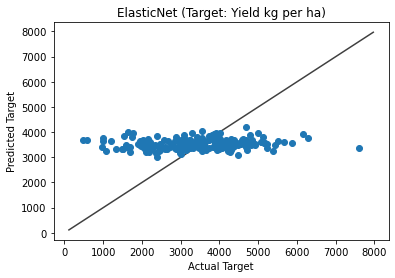

SVR
MAE on test data: 901.0396413752896
MAE Scaled on test data: 0.25112036515210445


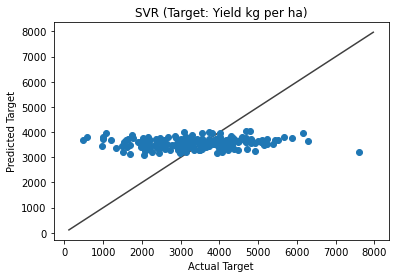

Lightgbm
MAE on test data: 899.7507295776024
MAE Scaled on test data: 0.25076114455134374


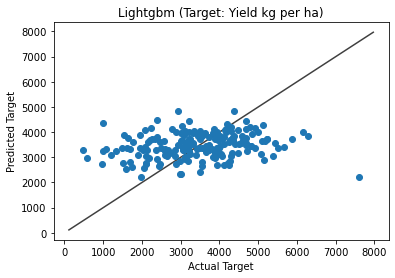

GBR
MAE on test data: 900.0306168478216
MAE Scaled on test data: 0.25083914932524204


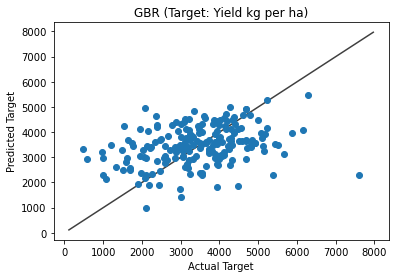

XGBoost
MAE on test data: 828.0648705734677
MAE Scaled on test data: 0.23078224655093632


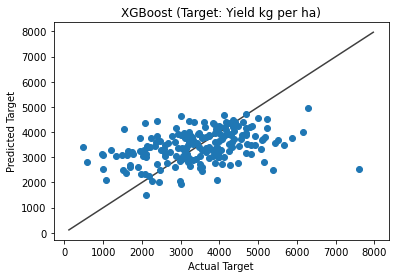

stackgen
MAE on test data: 978.3076038454064
MAE Scaled on test data: 0.23078224655093632


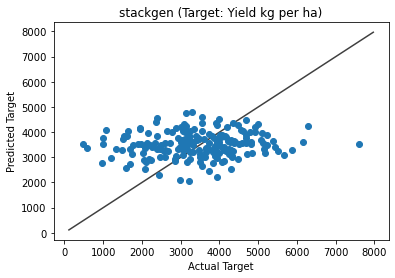

In [26]:
for model_name in model_names:
    print(model_name)
    print('MAE on test data: ' + str(Test_MAE_models[model_names.index(model_name)]))
    print('MAE Scaled on test data: ' + str(Test_Scaled_MAE_models[model_names.index(model_name)]))
    inv_transformed_y_actuals = power_transform_y.inverse_transform(y_test_yield_per_ha).reshape(-1, 1)
    inv_transformed_preds = power_transform_y.inverse_transform(fitted_models[model_names.index(model_name)].predict(X_test_yield_kg_per_ha).reshape(-1,1))
    fig, ax = plt.subplots()
    ax.scatter(inv_transformed_y_actuals, inv_transformed_preds)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Actual Target')
    plt.ylabel('Predicted Target')
    plt.title(model_name + ' (Target: Yield kg per ha)')
    plt.show()

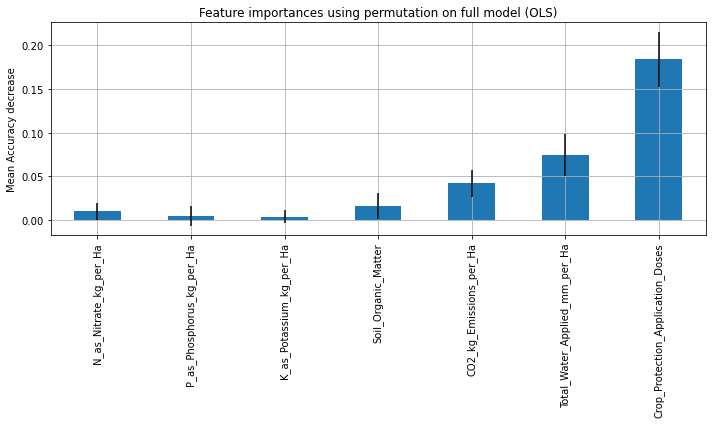

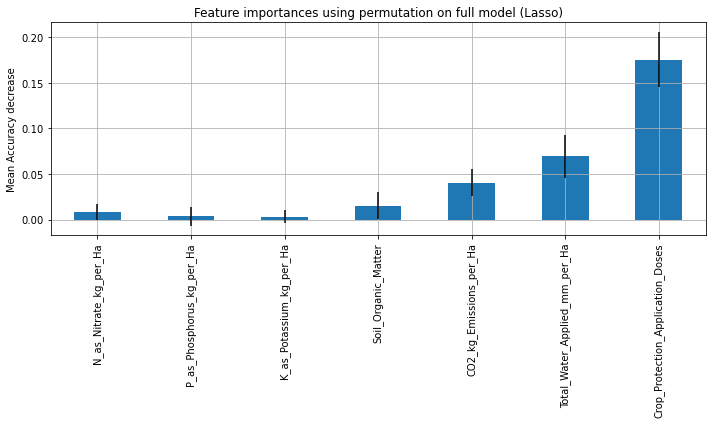

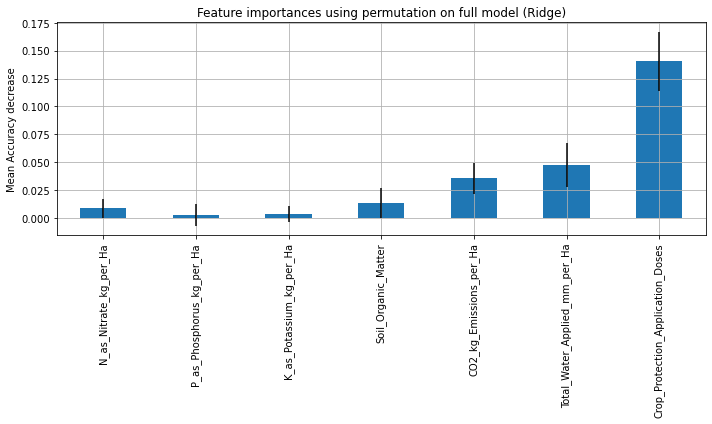

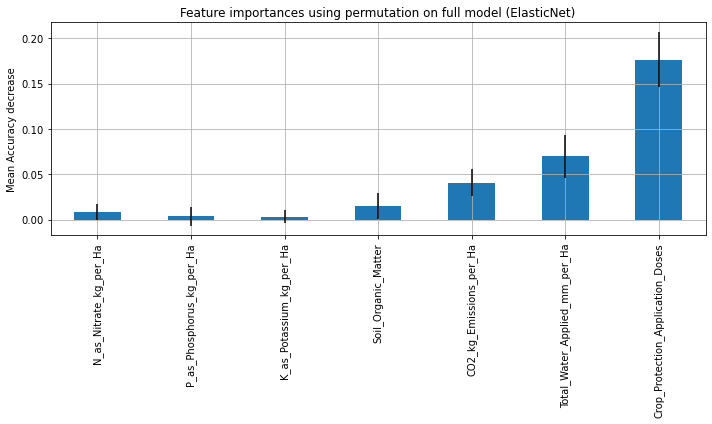

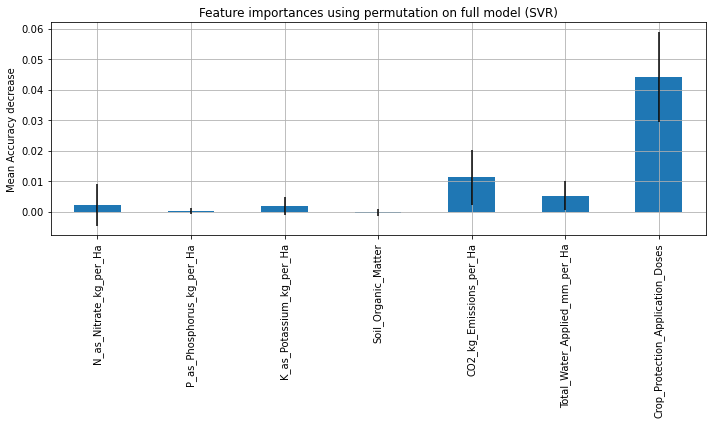

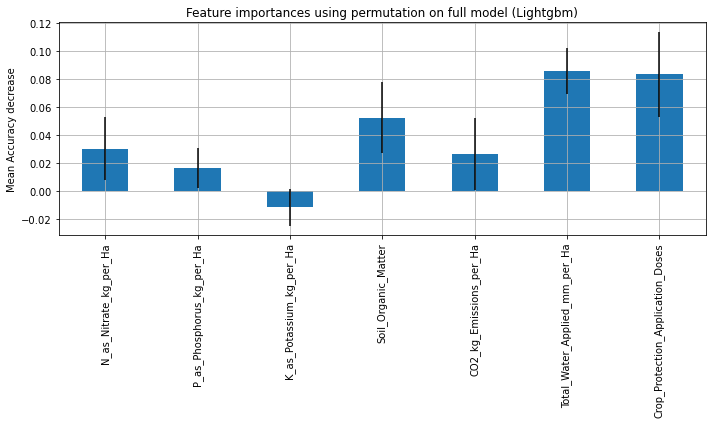

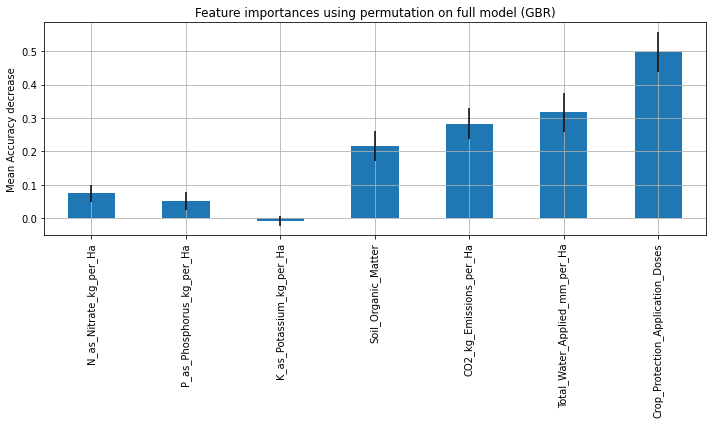

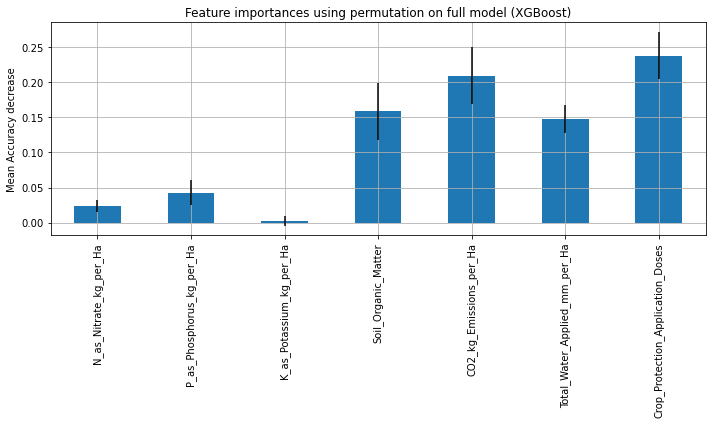

/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LassoCV was fitted without feature names
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names

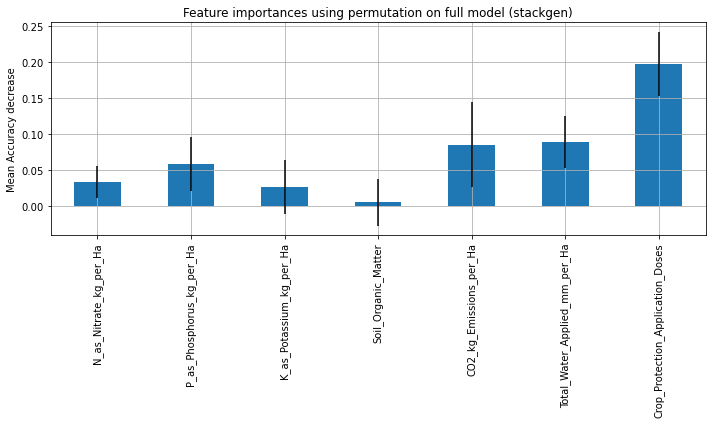

In [27]:
from sklearn.inspection import permutation_importance

for i in range(len(fitted_models)):
    feature_names = X_train_yield_kg_per_ha.columns

    result = permutation_importance(
        fitted_models[i], X_test_yield_kg_per_ha, y_test_yield_per_ha, n_repeats=10, random_state=42, n_jobs=2
    )

    model_importances = pd.Series(result.importances_mean, index = feature_names)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    model_importances.plot.bar(yerr = result.importances_std, ax = ax)
    ax.set_title("Feature importances using permutation on full model (" + str(model_names[i]) + ')')
    ax.set_ylabel("Mean Accuracy decrease")
    plt.grid()
    fig.tight_layout()
    plt.show()

In [ ]:
#Yeo-Johnson and Box Cox Transformation, water column retained
df = pd.read_csv('/mnt/Datasets/merged_dataframe_11_30_2022.csv').drop(columns = ['Unnamed: 0'])
df = df.drop(columns = ['Field_Name'])

print(display(df))

#train/test split
train_Yield_kg_per_ha, test_Yield_kg_per_ha = train_test_split(df, test_size = 0.2, random_state = 50)

#x values
X_train_yield_kg_per_ha = train_Yield_kg_per_ha.drop(columns = ['Yield_Mass_kg_Per_Ha'])
X_test_yield_kg_per_ha = test_Yield_kg_per_ha.drop(columns = ['Yield_Mass_kg_Per_Ha'])

power_transform_X = PowerTransformer(standardize = True).fit(X_train_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'CO2_kg_Emissions_per_Ha']])

X_train_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'CO2_kg_Emissions_per_Ha']] = \
power_transform_X.transform(X_train_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'CO2_kg_Emissions_per_Ha']])

X_test_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'CO2_kg_Emissions_per_Ha']] = \
power_transform_X.transform(X_test_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'CO2_kg_Emissions_per_Ha']])

power_transform_X_box_cox = PowerTransformer(standardize = True, method = 'box-cox').fit(X_train_yield_kg_per_ha[['Soil_Organic_Matter', 'Crop_Protection_Application_Doses', 'Total_Water_Applied_mm']])

X_train_yield_kg_per_ha[['Soil_Organic_Matter', 'Crop_Protection_Application_Doses', 'Total_Water_Applied_mm']] = \
power_transform_X_box_cox.transform(X_train_yield_kg_per_ha[['Soil_Organic_Matter', 'Crop_Protection_Application_Doses', 'Total_Water_Applied_mm']])

X_test_yield_kg_per_ha[['Soil_Organic_Matter', 'Crop_Protection_Application_Doses', 'Total_Water_Applied_mm']] = \
power_transform_X_box_cox.transform(X_test_yield_kg_per_ha[['Soil_Organic_Matter', 'Crop_Protection_Application_Doses', 'Total_Water_Applied_mm']])

#y_values
y_train_yield_per_ha = np.array(train_Yield_kg_per_ha['Yield_Mass_kg_Per_Ha']).reshape(-1, 1)
mean_Yield_kg_per_ha = y_train_yield_per_ha.mean()
y_test_yield_per_ha = np.array(test_Yield_kg_per_ha['Yield_Mass_kg_Per_Ha']).reshape(-1, 1)

power_transform_y = PowerTransformer(standardize = True, method = 'box-cox').fit(y_train_yield_per_ha)

y_train_yield_per_ha = power_transform_y.transform(y_train_yield_per_ha)
y_test_yield_per_ha = power_transform_y.transform(y_test_yield_per_ha)

In [ ]:
####Initialize K fold Cross validation
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

#####Grid Space for Lasso, Ridge, ElasticNet
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

####Model Building

model_names = ['OLS', 'Lasso', 'Ridge', 'ElasticNet', 'SVR', 'Lightgbm', 'GBR', 'XGBoost']
models = [linear_model.LinearRegression(), \
            LassoCV(max_iter = int(1e7), alphas = alphas2, random_state = 42, cv = kfolds), \
                  RidgeCV(alphas = alphas_alt, cv = kfolds), \
                  ElasticNetCV(max_iter = int(1e7), alphas = e_alphas, cv = kfolds, l1_ratio = e_l1ratio), \
                  SVR(C = 20, epsilon = 0.008, gamma = 0.0003), \
                  LGBMRegressor(objective='regression', num_leaves = 4, learning_rate = 0.01, n_estimators = 5000, max_bin = 200, bagging_fraction = 0.75, \
                                bagging_freq = 5, bagging_seed = 7, feature_fraction = 0.2, feature_fraction_seed = 7, verbose = -1), \
                  GradientBoostingRegressor(n_estimators = 5000, learning_rate = 0.05, max_depth = 4, max_features = 'sqrt', min_samples_leaf = 15, \
                                            min_samples_split = 10, loss = 'huber', random_state = 42), \
                  XGBRegressor(learning_rate = 0.005, n_estimators = 10000, max_depth = 3, min_child_weight = 0, gamma = 0, subsample = 0.7, \
                               colsample_bytree = 0.7, objective = 'reg:linear', nthread = -1, scale_pos_weight = 1, seed = 27, reg_alpha = 0.00006)
         ]

fitted_models = []
Test_MAE_models = []
Test_Scaled_MAE_models = []

for model in models:
    fitted_models.append(model.fit(X_train_yield_kg_per_ha, y_train_yield_per_ha))
    inv_transform_y_actuals = power_transform_y.inverse_transform(y_test_yield_per_ha).reshape(-1, 1)
    inv_transformed_preds = power_transform_y.inverse_transform(fitted_models[models.index(model)].predict(X_test_yield_kg_per_ha).reshape(-1,1))                                      
    Test_MAE_models.append(mae(inv_transform_y_actuals, inv_transformed_preds))
    Test_Scaled_MAE_models.append(Test_MAE_models[models.index(model)]/mean_Yield_kg_per_ha)
                                                                                                    
#stacked model
model_names.append('stackgen')
models.append(StackingCVRegressor(regressors = (models[0], models[1], models[2], models[3], models[4], models[5], models[6], models[7]), meta_regressor = models[6], use_features_in_secondary = True))
fitted_models.append(models[8].fit(X_train_yield_kg_per_ha, y_train_yield_per_ha))
inv_transform_y_actuals = power_transform_y.inverse_transform(y_test_yield_per_ha).reshape(-1,1)
inv_transformed_preds = power_transform_y.inverse_transform(fitted_models[8].predict(X_test_yield_kg_per_ha).reshape(-1,1))                                                 
Test_MAE_models.append(mae(inv_transform_y_actuals, inv_transformed_preds))
Test_Scaled_MAE_models.append(Test_MAE_models[8]/mean_Yield_kg_per_ha)

In [118]:
#Yeo-Johnson Scaling
df = pd.read_csv('/mnt/Datasets/merged_dataframe_11_30_2022.csv').drop(columns = ['Unnamed: 0'])
df = df.drop(columns = ['Field_Name'])

# print(df[df['N_as_Nitrate_kg_per_Ha'] != 0]['N_as_Nitrate_kg_per_Ha'].mean())

# df['N_as_Nitrate_kg_per_Ha'] = df['N_as_Nitrate_kg_per_Ha'].replace([0], [df[df['N_as_Nitrate_kg_per_Ha'] != 0]['N_as_Nitrate_kg_per_Ha'].mean()])
# df['P_as_Phosphorus_kg_per_Ha'] = df['P_as_Phosphorus_kg_per_Ha'].replace([0], [df[df['P_as_Phosphorus_kg_per_Ha'] != 0]['P_as_Phosphorus_kg_per_Ha'].mean()])
# df['K_as_Potassium_kg_per_Ha'] = df['K_as_Potassium_kg_per_Ha'].replace([0], [df[df['K_as_Potassium_kg_per_Ha'] != 0]['K_as_Potassium_kg_per_Ha'].mean()])

#train/test split

train_Yield_kg_per_ha, test_Yield_kg_per_ha = train_test_split(df, test_size = 0.2, random_state = 50)

# plt.figure()
# plt.title('Nitrate')
# plt.hist(np.log(1 + train_Yield_kg_per_ha['N_as_Nitrate_kg_per_Ha']))
# plt.figure()
# plt.title('Phosphorus')
# plt.hist(np.log(1 + train_Yield_kg_per_ha['P_as_Phosphorus_kg_per_Ha']))
# plt.figure()
# plt.title('Potassium')
# plt.hist(np.log(1 + train_Yield_kg_per_ha['K_as_Potassium_kg_per_Ha']))


# train_Yield_kg_per_ha['N_as_Nitrate_kg_per_Ha'] = np.log(1 + train_Yield_kg_per_ha['N_as_Nitrate_kg_per_Ha'])
# train_Yield_kg_per_ha['P_as_Phosphorus_kg_per_Ha'] = np.log(1 + train_Yield_kg_per_ha['P_as_Phosphorus_kg_per_Ha'])
# train_Yield_kg_per_ha['K_as_Potassium_kg_per_Ha'] = np.log(1 + train_Yield_kg_per_ha['K_as_Potassium_kg_per_Ha'])

# test_Yield_kg_per_ha['N_as_Nitrate_kg_per_Ha'] = np.log(1 + test_Yield_kg_per_ha['N_as_Nitrate_kg_per_Ha'])
# test_Yield_kg_per_ha['P_as_Phosphorus_kg_per_Ha'] = np.log(1 + test_Yield_kg_per_ha['P_as_Phosphorus_kg_per_Ha'])
# test_Yield_kg_per_ha['K_as_Potassium_kg_per_Ha'] = np.log(1 + test_Yield_kg_per_ha['K_as_Potassium_kg_per_Ha'])


#x values
X_train_yield_kg_per_ha = train_Yield_kg_per_ha.drop(columns = ['Yield_Mass_kg_Per_Ha'])
X_test_yield_kg_per_ha = test_Yield_kg_per_ha.drop(columns = ['Yield_Mass_kg_Per_Ha'])

standard_scaler_X = StandardScaler().fit(X_train_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'Soil_Organic_Matter', 'CO2_kg_Emissions_per_Ha']])

X_train_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'Soil_Organic_Matter', 'CO2_kg_Emissions_per_Ha']] = \
standard_scaler_X.transform(X_train_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'Soil_Organic_Matter', 'CO2_kg_Emissions_per_Ha']])

X_test_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'Soil_Organic_Matter', 'CO2_kg_Emissions_per_Ha']] = \
standard_scaler_X.transform(X_test_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'Soil_Organic_Matter', 'CO2_kg_Emissions_per_Ha']])

# power_transform_X_box_cox = PowerTransformer(standardize = True).fit(X_train_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha']])

# X_train_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha']] = \
# power_transform_X_box_cox.transform(X_train_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha']])

# plt.figure()
# plt.title('Nitrate')
# plt.hist(X_train_yield_kg_per_ha['N_as_Nitrate_kg_per_Ha'])
# plt.figure()
# plt.title('Phosphorus')
# plt.hist(X_train_yield_kg_per_ha['P_as_Phosphorus_kg_per_Ha'])
# plt.figure()
# plt.title('Potassium')
# plt.hist(X_train_yield_kg_per_ha['K_as_Potassium_kg_per_Ha'])




# power_transform_X_box_cox = PowerTransformer(standardize = True, method = 'box-cox').fit(X_train_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'Soil_Organic_Matter']])
# power_transform_X_box_cox = PowerTransformer(standardize = True, method = 'box-cox').fit(X_train_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha']])

# X_train_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'Soil_Organic_Matter']] = \
# power_transform_X_box_cox.transform(X_train_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'Soil_Organic_Matter']])

# X_train_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'Soil_Organic_Matter']] = \
# power_transform_X_box_cox.transform(X_train_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'Soil_Organic_Matter']])

# plt.figure()
# plt.title('Nitrate')
# plt.hist(X_train_yield_kg_per_ha['N_as_Nitrate_kg_per_Ha'])
# plt.figure()
# plt.title('Phosphorus')
# plt.hist(X_train_yield_kg_per_ha['P_as_Phosphorus_kg_per_Ha'])
# plt.figure()
# plt.title('Potassium')
# plt.hist(X_train_yield_kg_per_ha['K_as_Potassium_kg_per_Ha'])

# X_test_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'Soil_Organic_Matter']] = \
# power_transform_X_box_cox.transform(X_test_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'Soil_Organic_Matter']])

# power_transform_X_yeo_johnson = PowerTransformer(standardize = True).fit(X_train_yield_kg_per_ha[['CO2_kg_Emissions_per_Ha']])

# X_train_yield_kg_per_ha[['CO2_kg_Emissions_per_Ha']] = power_transform_X_yeo_johnson.transform(X_train_yield_kg_per_ha[['CO2_kg_Emissions_per_Ha']])

# X_test_yield_kg_per_ha[['CO2_kg_Emissions_per_Ha']] = power_transform_X_yeo_johnson.transform(X_test_yield_kg_per_ha[['CO2_kg_Emissions_per_Ha']])

# plt.figure()
# plt.title('Soil Organic Matter')
# plt.hist(X_train_yield_kg_per_ha['Soil_Organic_Matter'])
# plt.figure()
# plt.title('CO2_kg_Emissions_per_Ha')
# plt.hist(X_train_yield_kg_per_ha['CO2_kg_Emissions_per_Ha'])

# print(display(X_train_yield_kg_per_ha.agg(['skew', 'kurtosis']).transpose()))

#y_values
y_train_yield_kg_per_ha = np.array(train_Yield_kg_per_ha['Yield_Mass_kg_Per_Ha']).reshape(-1, 1)

y_test_yield_kg_per_ha = np.array(test_Yield_kg_per_ha['Yield_Mass_kg_Per_Ha']).reshape(-1, 1)

mean_yield_kg_per_ha = y_train_yield_kg_per_ha.mean()

standard_scaler_y = StandardScaler().fit(y_train_yield_kg_per_ha)

y_train_yield_kg_per_ha = standard_scaler_y.transform(y_train_yield_kg_per_ha)
y_test_yield_kg_per_ha = standard_scaler_y.transform(y_test_yield_kg_per_ha)


# power_transform_y = PowerTransformer(standardize = True, method = 'box-cox').fit(y_train_yield_per_ha)

# y_train_yield_per_ha = power_transform_y.transform(y_train_yield_per_ha)

# y_test_yield_per_ha = power_transform_y.transform(y_test_yield_per_ha)

# plt.figure()
# plt.hist(y_train_yield_per_ha)

In [49]:
####Initialize K fold Cross validation
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

#####Grid Space for Lasso, Ridge, ElasticNet
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

####Model Building

model_names = ['OLS', 'Lasso', 'Ridge', 'ElasticNet', 'SVR', 'Lightgbm', 'GBR', 'XGBoost']
models = [linear_model.LinearRegression(), \
            LassoCV(max_iter = int(1e7), alphas = alphas2, random_state = 42, cv = kfolds), \
                  RidgeCV(alphas = alphas_alt, cv = kfolds), \
                  ElasticNetCV(max_iter = int(1e7), alphas = e_alphas, cv = kfolds, l1_ratio = e_l1ratio), \
                  SVR(C = 20, epsilon = 0.008, gamma = 0.0003), \
                  LGBMRegressor(objective='regression', num_leaves = 4, learning_rate = 0.01, n_estimators = 5000, max_bin = 200, bagging_fraction = 0.75, \
                                bagging_freq = 5, bagging_seed = 7, feature_fraction = 0.2, feature_fraction_seed = 7, verbose = -1), \
                  GradientBoostingRegressor(n_estimators = 5000, learning_rate = 0.05, max_depth = 4, max_features = 'sqrt', min_samples_leaf = 15, \
                                            min_samples_split = 10, loss = 'huber', random_state = 42), \
                  XGBRegressor(learning_rate = 0.005, n_estimators = 10000, max_depth = 3, min_child_weight = 0, gamma = 0, subsample = 0.7, \
                               colsample_bytree = 0.7, objective = 'reg:linear', nthread = -1, scale_pos_weight = 1, seed = 27, reg_alpha = 0.00006)
         ]

fitted_models = []
Test_MAE_models = []
Test_Scaled_MAE_models = []

for model in models:
    fitted_models.append(model.fit(X_train_yield_kg_per_ha, y_train_yield_per_ha))
    inv_transform_y_actuals = power_transform_y.inverse_transform(y_test_yield_per_ha).reshape(-1, 1)
    inv_transformed_preds = power_transform_y.inverse_transform(fitted_models[models.index(model)].predict(X_test_yield_kg_per_ha).reshape(-1,1))                                             
    Test_MAE_models.append(mae(inv_transform_y_actuals, inv_transformed_preds))
    Test_Scaled_MAE_models.append(Test_MAE_models[models.index(model)]/mean_yield_kg_per_ha)
                                                                                                    
#stacked model
model_names.append('stackgen')
models.append(StackingCVRegressor(regressors = (models[0], models[1], models[2], models[3], models[4], models[5], models[6], models[7]), meta_regressor = models[7], use_features_in_secondary = True))
fitted_models.append(models[8].fit(X_train_yield_kg_per_ha, y_train_yield_per_ha))
inv_transform_y_actuals = power_transform_y.inverse_transform(y_test_yield_per_ha).reshape(-1,1)
inv_transformed_preds = power_transform_y.inverse_transform(fitted_models[8].predict(X_test_yield_kg_per_ha).reshape(-1,1))                                              
Test_MAE_models.append(mae(inv_transform_y_actuals, inv_transformed_preds))
Test_Scaled_MAE_models.append(Test_MAE_models[models.index(model)]/mean_yield_kg_per_ha)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[16:52:19] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_f

OLS
MAE on test data: 901.8026049388084
MAE Scaled on test data: 0.2574879177822757


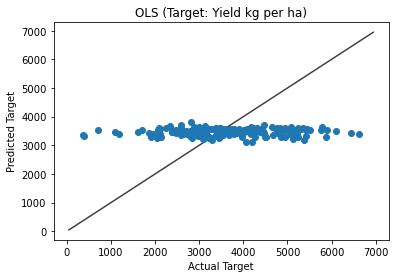

Lasso
MAE on test data: 901.6032321981501
MAE Scaled on test data: 0.25743099171932854


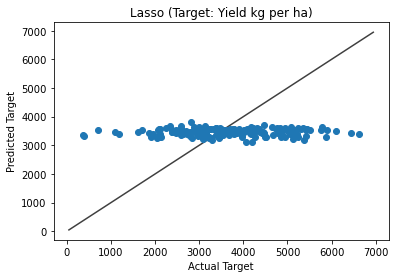

Ridge
MAE on test data: 901.4737734651844
MAE Scaled on test data: 0.25739402790994553


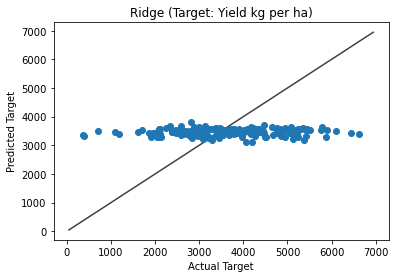

ElasticNet
MAE on test data: 901.6281440533116
MAE Scaled on test data: 0.25743810469691203


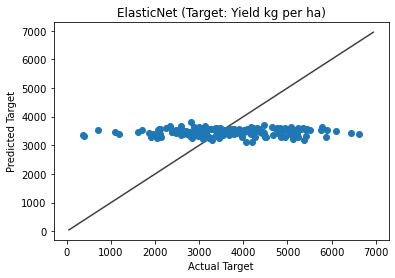

SVR
MAE on test data: 904.9852285566353
MAE Scaled on test data: 0.258396638963553


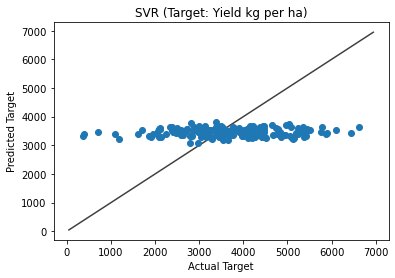

Lightgbm
MAE on test data: 890.3045613679146
MAE Scaled on test data: 0.25420492959680663


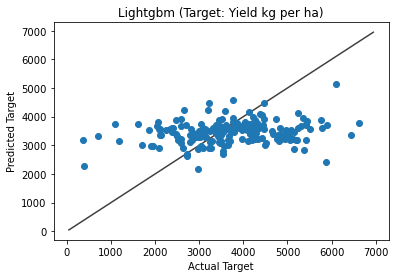

GBR
MAE on test data: 919.6023746260356
MAE Scaled on test data: 0.26257021141135567


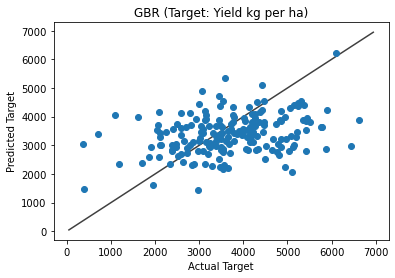

XGBoost
MAE on test data: 868.4521785710308
MAE Scaled on test data: 0.24796551033350497


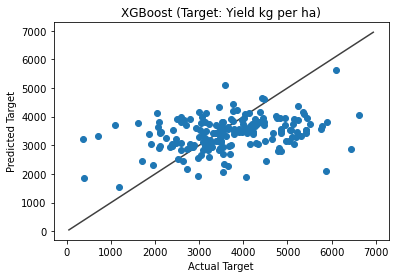

stackgen
MAE on test data: 1014.6327779892628
MAE Scaled on test data: 0.24796551033350497


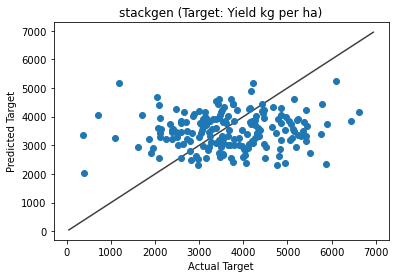

In [51]:
for model_name in model_names:
    print(model_name)
    print('MAE on test data: ' + str(Test_MAE_models[model_names.index(model_name)]))
    print('MAE Scaled on test data: ' + str(Test_Scaled_MAE_models[model_names.index(model_name)]))
    inv_transformed_y_actuals = power_transform_y.inverse_transform(y_test_yield_per_ha).reshape(-1, 1)
    inv_transformed_preds = power_transform_y.inverse_transform(fitted_models[model_names.index(model_name)].predict(X_test_yield_kg_per_ha).reshape(-1,1))
    fig, ax = plt.subplots()
    ax.scatter(inv_transformed_y_actuals, inv_transformed_preds)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Actual Target')
    plt.ylabel('Predicted Target')
    plt.title(model_name + ' (Target: Yield kg per ha)')
    plt.show()

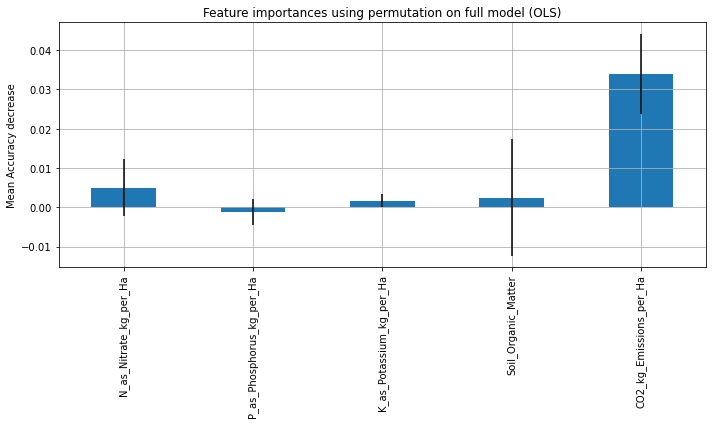

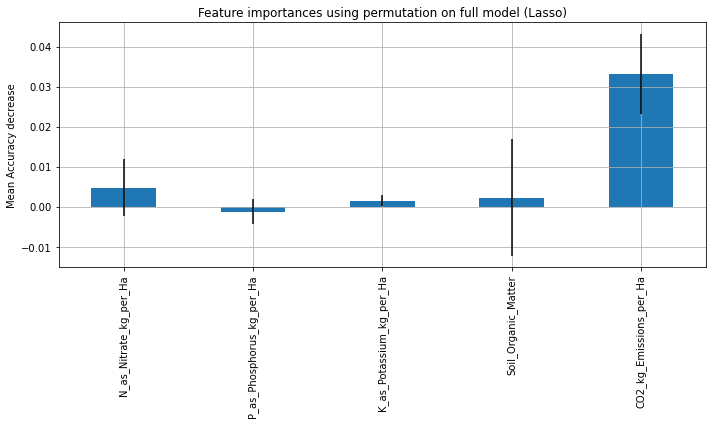

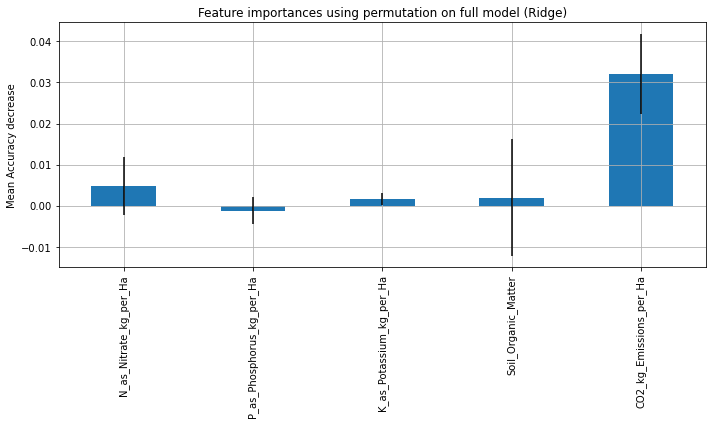

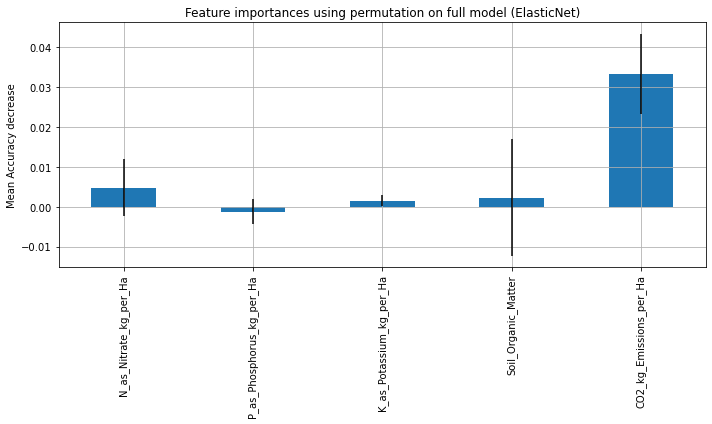

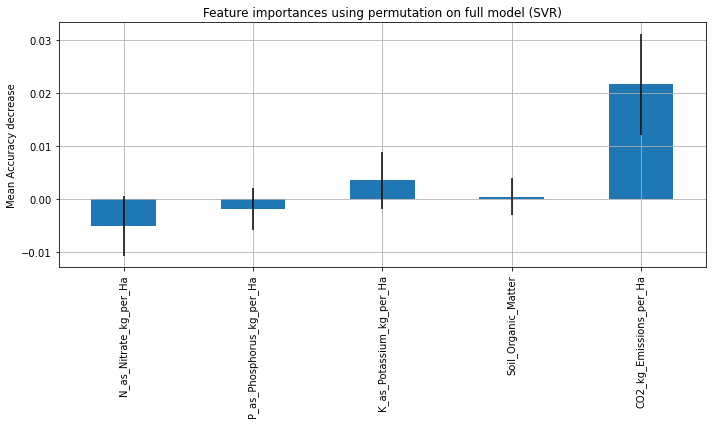

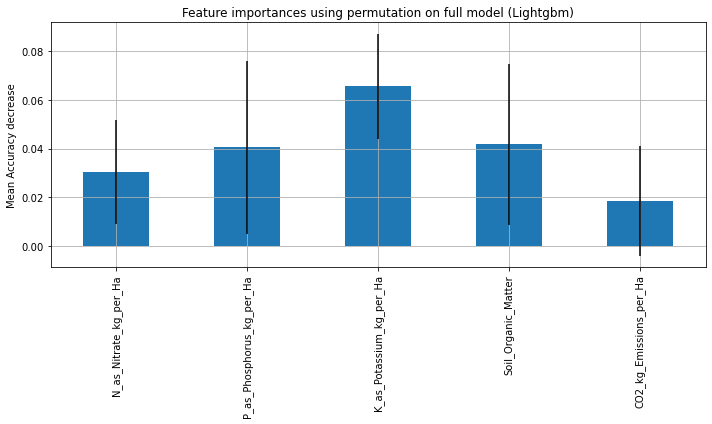

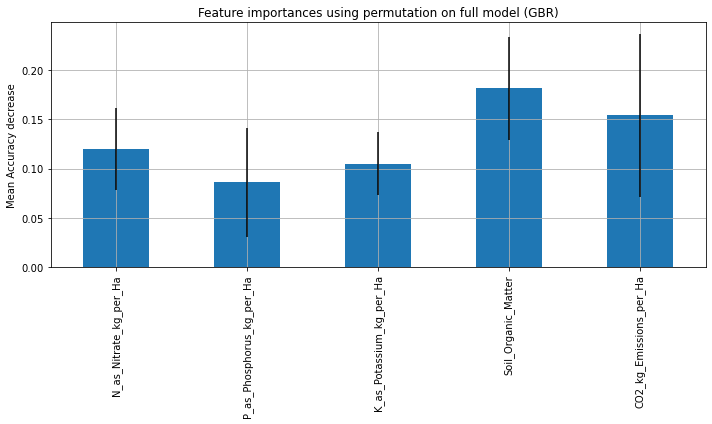

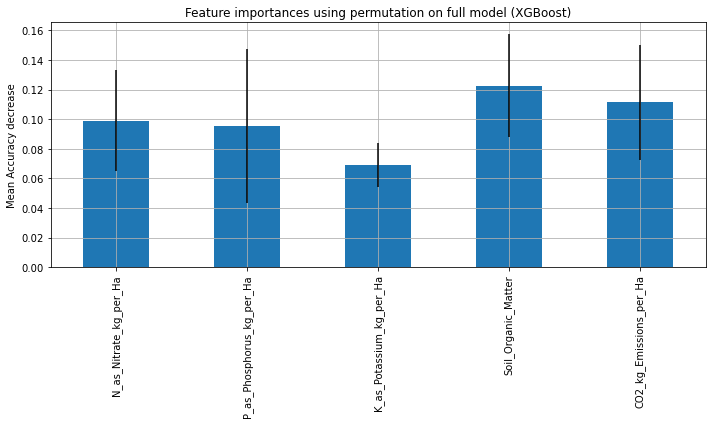

/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LassoCV was fitted without feature names
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names

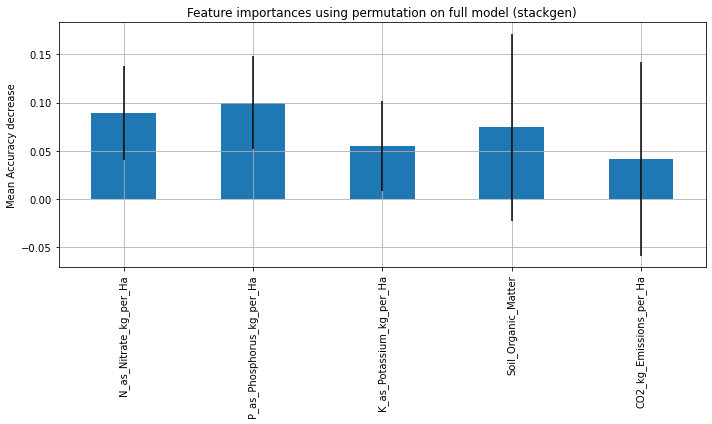

In [52]:
from sklearn.inspection import permutation_importance

for i in range(len(fitted_models)):
    feature_names = X_train_yield_kg_per_ha.columns

    result = permutation_importance(
        fitted_models[i], X_test_yield_kg_per_ha, y_test_yield_per_ha, n_repeats=10, random_state=42, n_jobs=2
    )

    model_importances = pd.Series(result.importances_mean, index = feature_names)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    model_importances.plot.bar(yerr = result.importances_std, ax = ax)
    ax.set_title("Feature importances using permutation on full model (" + str(model_names[i]) + ')')
    ax.set_ylabel("Mean Accuracy decrease")
    plt.grid()
    fig.tight_layout()
    plt.show()

,N_as_Nitrate_kg_per_Ha,P_as_Phosphorus_kg_per_Ha,K_as_Potassium_kg_per_Ha,Soil_Organic_Matter,Yield_Mass_kg_Per_Ha,CO2_kg_Emissions_per_Ha,Total_Water_Applied_mm,Crop_Protection_Application_Doses
0,6000.0,0.0,6000.0,2.50,4786.900000,349.85,350,14
1,6600.0,0.0,6600.0,2.50,5234.476190,488.41,350,18
2,6000.0,0.0,6000.0,2.50,4358.380952,462.26,350,20
3,0.0,0.0,0.0,2.50,3400.400000,409.14,350,10
4,0.0,0.0,0.0,2.50,3033.000000,261.38,350,15
...,...,...,...,...,...,...,...,...
971,0.0,0.0,0.0,2.69,4587.384615,449.67,450,16
972,0.0,0.0,0.0,5.38,6741.676647,-1035.15,450,15
973,0.0,0.0,0.0,5.38,6482.275449,-1092.21,450,13
974,0.0,0.0,0.0,3.75,3372.689076,-427.99,450,15


None
1
0.4365366837639895


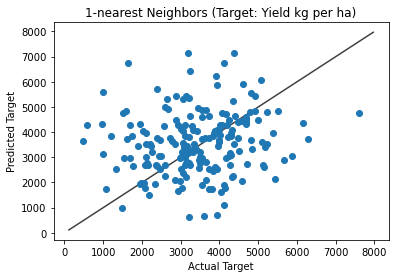

2
0.386349770262722


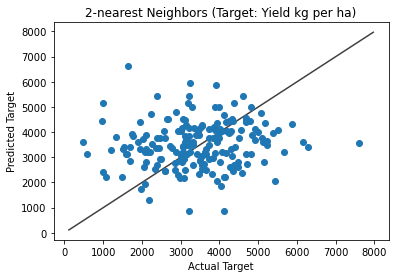

3
0.3467219943357312


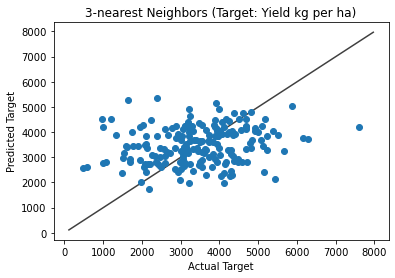

4
0.3327145679947518


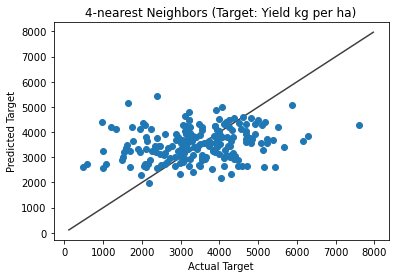

5
0.3323052531092857


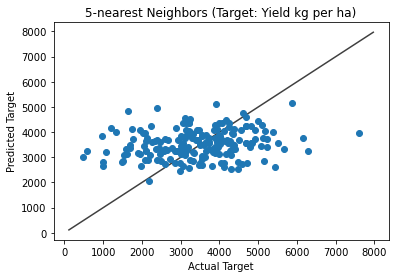

6
0.32721767758459797


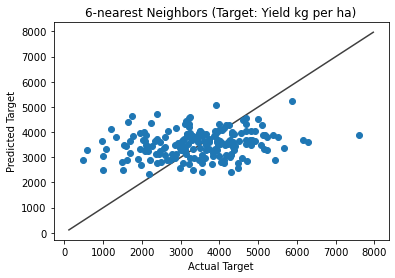

7
0.3325704341080782


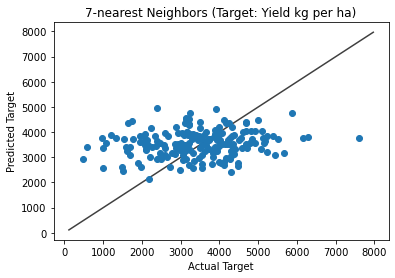

8
0.33171014869072024


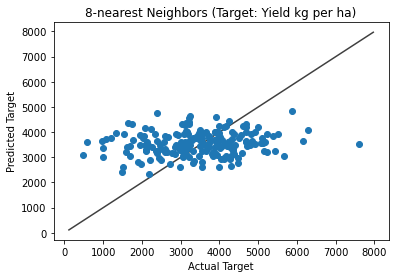

9
0.3281537724377368


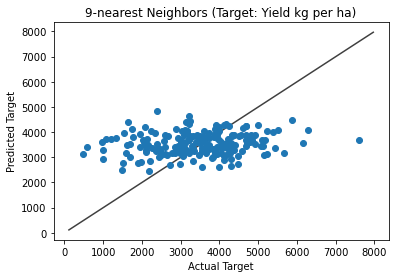

10
0.32487114537296413


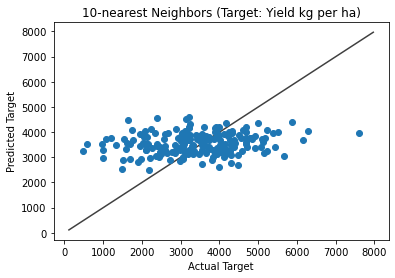

11
0.3224192041120944


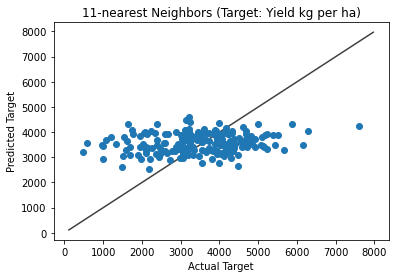

12
0.3214150812998889


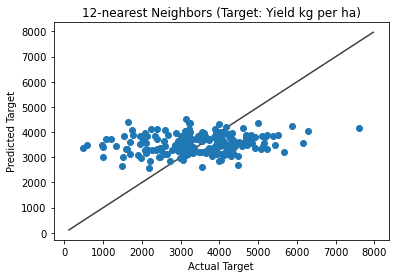

13
0.3191224559767696


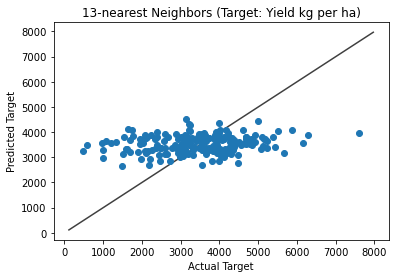

14
0.3173689951270871


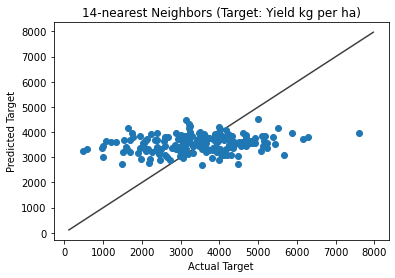

15
0.3169433160804968


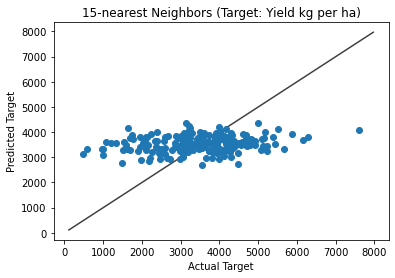

16
0.3178485097160377


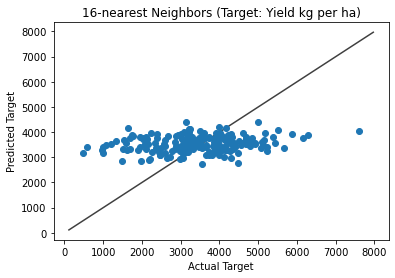

17
0.31766723194305846


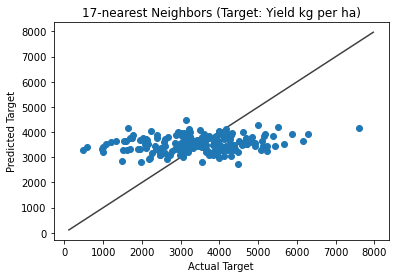

18
0.31952868127199924


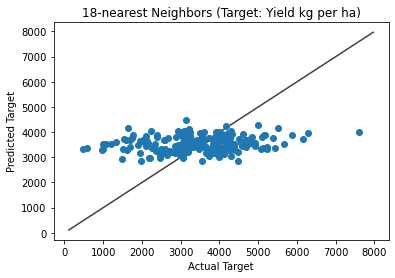

19
0.32025065243098083


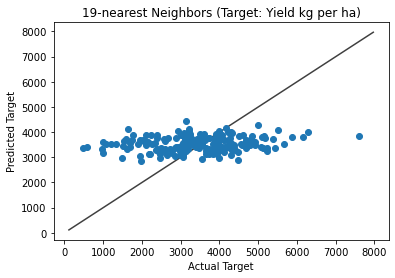

20
0.3214603213461251


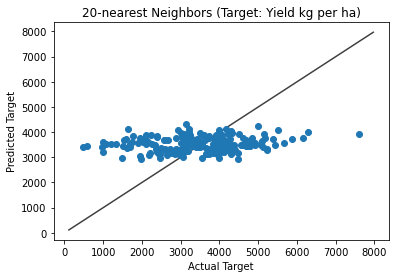

21
0.32181383443512257


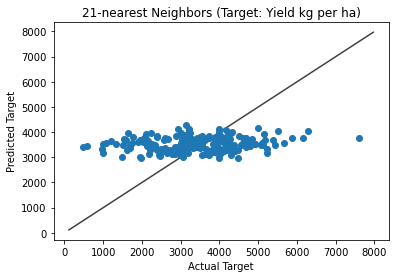

22
0.32324880347750856


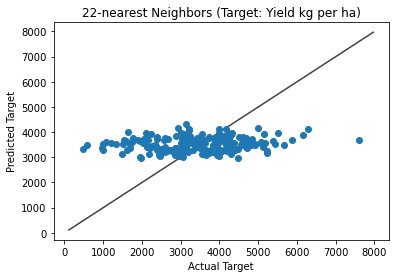

23
0.3262124316752697


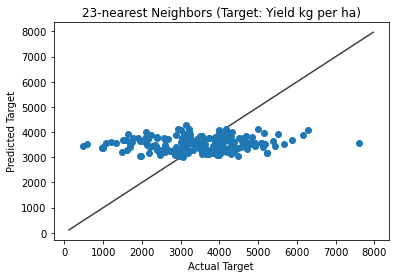

24
0.32638732668670367


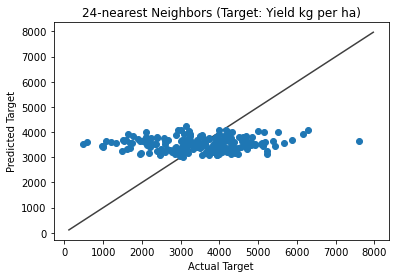

In [7]:
#K nearest neighbors (standard normal scaled data)

#Yeo-Johnson and Box Cox Transformation, water column retained
df = pd.read_csv('/mnt/Datasets/merged_dataframe_11_30_2022.csv').drop(columns = ['Unnamed: 0'])
df = df.drop(columns = ['Field_Name'])

print(display(df))

#train/test split
train_Yield_kg_per_ha, test_Yield_kg_per_ha = train_test_split(df, test_size = 0.2, random_state = 50)

#x values
X_train_yield_kg_per_ha = train_Yield_kg_per_ha.drop(columns = ['Yield_Mass_kg_Per_Ha'])
X_test_yield_kg_per_ha = test_Yield_kg_per_ha.drop(columns = ['Yield_Mass_kg_Per_Ha'])

power_transform_X = PowerTransformer(standardize = True).fit(X_train_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'CO2_kg_Emissions_per_Ha']])

X_train_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'CO2_kg_Emissions_per_Ha']] = \
power_transform_X.transform(X_train_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'CO2_kg_Emissions_per_Ha']])

X_test_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'CO2_kg_Emissions_per_Ha']] = \
power_transform_X.transform(X_test_yield_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'CO2_kg_Emissions_per_Ha']])

power_transform_X_box_cox = PowerTransformer(standardize = True, method = 'box-cox').fit(X_train_yield_kg_per_ha[['Soil_Organic_Matter', 'Crop_Protection_Application_Doses', 'Total_Water_Applied_mm']])

X_train_yield_kg_per_ha[['Soil_Organic_Matter', 'Crop_Protection_Application_Doses', 'Total_Water_Applied_mm']] = \
power_transform_X_box_cox.transform(X_train_yield_kg_per_ha[['Soil_Organic_Matter', 'Crop_Protection_Application_Doses', 'Total_Water_Applied_mm']])

X_test_yield_kg_per_ha[['Soil_Organic_Matter', 'Crop_Protection_Application_Doses', 'Total_Water_Applied_mm']] = \
power_transform_X_box_cox.transform(X_test_yield_kg_per_ha[['Soil_Organic_Matter', 'Crop_Protection_Application_Doses', 'Total_Water_Applied_mm']])

#y_values
y_train_yield_per_ha = np.array(train_Yield_kg_per_ha['Yield_Mass_kg_Per_Ha']).reshape(-1, 1)
mean_Yield_kg_per_ha = y_train_yield_per_ha.mean()
y_test_yield_per_ha = np.array(test_Yield_kg_per_ha['Yield_Mass_kg_Per_Ha']).reshape(-1, 1)

power_transform_y = PowerTransformer(standardize = True, method = 'box-cox').fit(y_train_yield_per_ha)

y_train_yield_per_ha = power_transform_y.transform(y_train_yield_per_ha)
y_test_yield_per_ha = power_transform_y.transform(y_test_yield_per_ha)

from sklearn.neighbors import KNeighborsRegressor

k_values = np.arange(1,25,1)

for k in k_values:
    print(str(k))
    neigh = KNeighborsRegressor(n_neighbors = k)
    neigh.fit(X_train_yield_kg_per_ha, y_train_yield_per_ha)
    print(rmse(power_transform_y.inverse_transform(neigh.predict(X_test_yield_kg_per_ha)), power_transform_y.inverse_transform(y_test_yield_per_ha))/mean_Yield_kg_per_ha)
    fig, ax = plt.subplots()
    ax.scatter(power_transform_y.inverse_transform(y_test_yield_per_ha), power_transform_y.inverse_transform(neigh.predict(X_test_yield_kg_per_ha)))
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Actual Target')
    plt.ylabel('Predicted Target')
    plt.title(str(k) + '-nearest Neighbors (Target: Yield kg per ha)')
    plt.show()    

(array([566.,  10.,  26.,  13.,  37.,  27.,  25.,  35.,   6.,   4.]),
 array([0.41692304, 0.57017092, 0.7234188 , 0.87666668, 1.02991456,
        1.18316245, 1.33641033, 1.48965821, 1.64290609, 1.79615397,
        1.94940185]),
 <BarContainer object of 10 artists>)

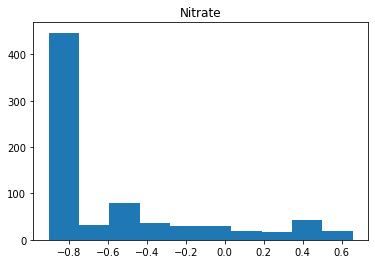

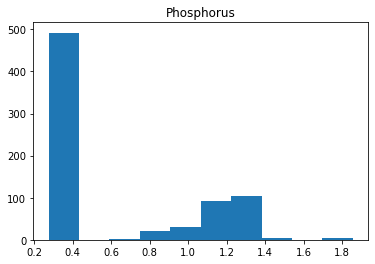

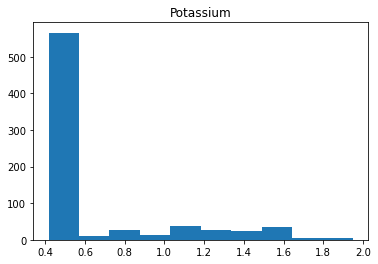

In [151]:
#Using CO2 prediction model to find yield

#K nearest neighbors (standard normal scaled data)
df = pd.read_csv('/mnt/Datasets/merged_dataframe_11_30_2022.csv').drop(columns = ['Unnamed: 0'])
df = df.drop(columns = ['Field_Name'])

#train/test split
train_CO2_kg_per_ha, test_CO2_kg_per_ha = train_test_split(df, test_size = 0.2, random_state = 50)

#x values
X_train_CO2_kg_per_ha = train_CO2_kg_per_ha.drop(columns = ['CO2_kg_Emissions_per_Ha'])
X_test_CO2_kg_per_ha = test_CO2_kg_per_ha.drop(columns = ['CO2_kg_Emissions_per_Ha'])

standard_scaler_X = StandardScaler().fit(X_train_CO2_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'Soil_Organic_Matter', 'Yield_Mass_kg_Per_Ha']])

X_train_CO2_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'Soil_Organic_Matter', 'Yield_Mass_kg_Per_Ha']] = \
standard_scaler_X.transform(X_train_CO2_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'Soil_Organic_Matter', 'Yield_Mass_kg_Per_Ha']])

X_test_CO2_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'Soil_Organic_Matter', 'Yield_Mass_kg_Per_Ha']] = \
standard_scaler_X.transform(X_test_CO2_kg_per_ha[['N_as_Nitrate_kg_per_Ha','P_as_Phosphorus_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'Soil_Organic_Matter', 'Yield_Mass_kg_Per_Ha']])

#y values
y_train_CO2_kg_per_ha = np.array(train_CO2_kg_per_ha['CO2_kg_Emissions_per_Ha']).reshape(-1, 1)
y_test_CO2_kg_per_ha = np.array(test_CO2_kg_per_ha['CO2_kg_Emissions_per_Ha']).reshape(-1, 1)

mean_CO2_kg_per_ha = y_train_CO2_kg_per_ha.mean()

standard_scaler_y = StandardScaler().fit(y_train_CO2_kg_per_ha)

y_train_CO2_kg_per_ha = standard_scaler_y.transform(y_train_CO2_kg_per_ha)
y_test_CO2_kg_per_ha = standard_scaler_y.transform(y_test_CO2_kg_per_ha)

In [131]:
####Initialize K fold Cross validation
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

#####Grid Space for Lasso, Ridge, ElasticNet
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

####Model Building

model_names = ['OLS', 'Lasso', 'Ridge', 'ElasticNet', 'SVR', 'Lightgbm', 'GBR', 'XGBoost']
models = [linear_model.LinearRegression(), \
            LassoCV(max_iter = int(1e7), alphas = alphas2, random_state = 42, cv = kfolds), \
                  RidgeCV(alphas = alphas_alt, cv = kfolds), \
                  ElasticNetCV(max_iter = int(1e7), alphas = e_alphas, cv = kfolds, l1_ratio = e_l1ratio), \
                  SVR(C = 20, epsilon = 0.008, gamma = 0.0003), \
                  LGBMRegressor(objective='regression', num_leaves = 4, learning_rate = 0.01, n_estimators = 5000, max_bin = 200, bagging_fraction = 0.75, \
                                bagging_freq = 5, bagging_seed = 7, feature_fraction = 0.2, feature_fraction_seed = 7, verbose = -1), \
                  GradientBoostingRegressor(n_estimators = 5000, learning_rate = 0.05, max_depth = 4, max_features = 'sqrt', min_samples_leaf = 15, \
                                            min_samples_split = 10, loss = 'huber', random_state = 42), \
                  XGBRegressor(learning_rate = 0.005, n_estimators = 10000, max_depth = 3, min_child_weight = 0, gamma = 0, subsample = 0.7, \
                               colsample_bytree = 0.7, objective = 'reg:linear', nthread = -1, scale_pos_weight = 1, seed = 27, reg_alpha = 0.00006)
         ]

fitted_models = []
Test_MAE_models = []
Test_Scaled_MAE_models = []

for model in models:
    fitted_models.append(model.fit(X_train_CO2_kg_per_ha, y_train_CO2_kg_per_ha))
    inv_transform_y_actuals = standard_scaler_y.inverse_transform(y_test_CO2_kg_per_ha).reshape(-1, 1)
    inv_transformed_preds = standard_scaler_y.inverse_transform(fitted_models[models.index(model)].predict(X_test_CO2_kg_per_ha).reshape(-1,1))                                             
    Test_MAE_models.append(mae(inv_transform_y_actuals, inv_transformed_preds))
    Test_Scaled_MAE_models.append(Test_MAE_models[models.index(model)]/mean_CO2_kg_per_ha)
                                                                                                    
#stacked model
model_names.append('stackgen')
models.append(StackingCVRegressor(regressors = (models[0], models[1], models[2], models[3], models[4], models[5], models[6], models[7]), meta_regressor = models[7], use_features_in_secondary = True))
fitted_models.append(models[8].fit(X_train_CO2_kg_per_ha, y_train_CO2_kg_per_ha))
inv_transform_y_actuals = standard_scaler_y.inverse_transform(y_test_CO2_kg_per_ha).reshape(-1,1)
inv_transformed_preds = standard_scaler_y.inverse_transform(fitted_models[8].predict(X_test_CO2_kg_per_ha).reshape(-1,1))                                              
Test_MAE_models.append(mae(inv_transform_y_actuals, inv_transformed_preds))
Test_Scaled_MAE_models.append(Test_MAE_models[models.index(model)]/mean_CO2_kg_per_ha)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[20:57:40] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_f

OLS
MAE on test data: 552.1965557031102
MAE Scaled on test data: 1.3668512539373587


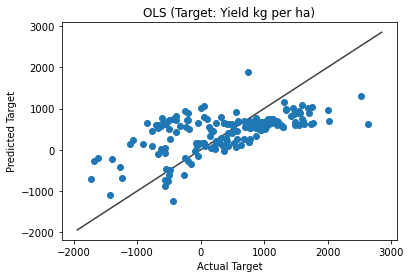

Lasso
MAE on test data: 552.2998476567725
MAE Scaled on test data: 1.3671069323455756


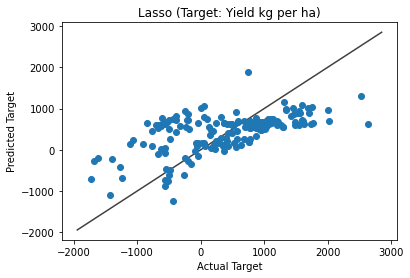

Ridge
MAE on test data: 553.2162677967236
MAE Scaled on test data: 1.3693753456569022


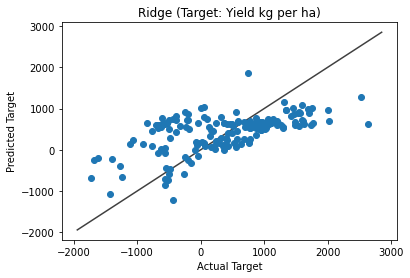

ElasticNet
MAE on test data: 552.286614620366
MAE Scaled on test data: 1.3670741766316565


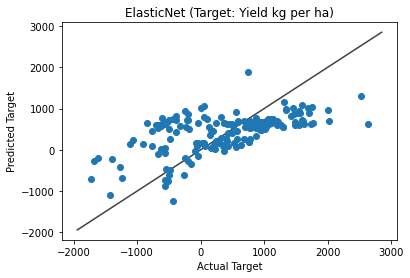

SVR
MAE on test data: 532.0577690780932
MAE Scaled on test data: 1.3170017475127276


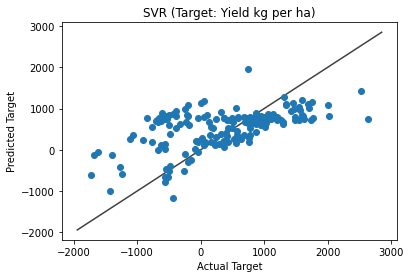

Lightgbm
MAE on test data: 520.6909926402805
MAE Scaled on test data: 1.288865583918829


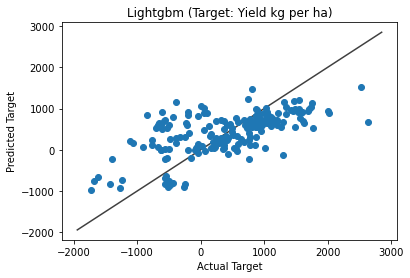

GBR
MAE on test data: 499.3884099867285
MAE Scaled on test data: 1.2361353350402635


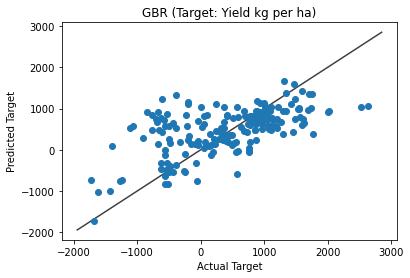

XGBoost
MAE on test data: 506.33965115648635
MAE Scaled on test data: 1.253341731225054


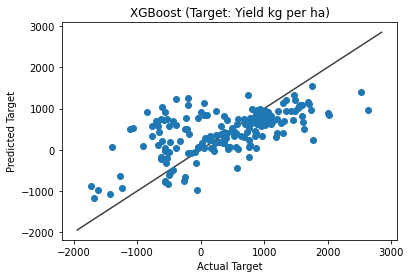

stackgen
MAE on test data: 521.6332367556653
MAE Scaled on test data: 1.253341731225054


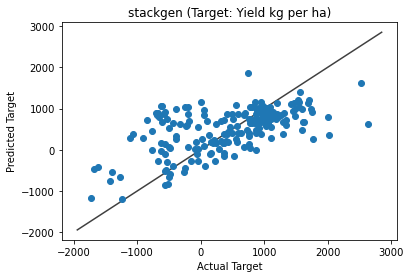

In [132]:
for model_name in model_names:
    print(model_name)
    print('MAE on test data: ' + str(Test_MAE_models[model_names.index(model_name)]))
    print('MAE Scaled on test data: ' + str(Test_Scaled_MAE_models[model_names.index(model_name)]))
    inv_transformed_y_actuals = standard_scaler_y.inverse_transform(y_test_CO2_kg_per_ha).reshape(-1, 1)
    inv_transformed_preds = standard_scaler_y.inverse_transform(fitted_models[model_names.index(model_name)].predict(X_test_CO2_kg_per_ha).reshape(-1,1))
    fig, ax = plt.subplots()
    ax.scatter(inv_transformed_y_actuals, inv_transformed_preds)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Actual Target')
    plt.ylabel('Predicted Target')
    plt.title(model_name + ' (Target: Yield kg per ha)')
    plt.show()

In [197]:
coef = fitted_models[0].coef_
intercept = fitted_models[0].intercept_
backsolve_df = X_test_CO2_kg_per_ha.to_numpy()[:,:-1]

print(y_test_CO2_kg_per_ha.shape)
print(np.array([np.sum(np.multiply(backsolve_df, coef[0][0:4], backsolve_df), axis = 1)]).T.shape)
print(intercept.shape)

print(mae(standard_scaler_y.inverse_transform((y_test_CO2_kg_per_ha - intercept - np.array([np.sum(np.multiply(backsolve_df, coef[0][0:4], backsolve_df), axis = 1)]).T)/coef[0][4]), backsolve_df[-1]))

# print(y_test_CO2_kg_per_ha - intercept - np.matmul(coef[0][0:4], backsolve_df))

# print((y_test_CO2_kg_per_ha - np.sum(np.multiply(coef[0][0:4], backsolve_df), axis = 0) - intercept)/coef[0][-1])


(188, 1)
(188, 1)
(1,)
10313.240545884948
